# Data Loading and Transformation

## Import packages

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q datasets
!pip install accelerate -U
! pip install evaluate
!pip install transformers

In [ ]:
%pip install -U neptune transformers[torch,sklearn] datasets evaluate scipy
# Runtime restart

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback, AutoModelForCausalLM, AutoModelForSeq2SeqLM,BitsAndBytesConfig, DataCollatorWithPadding
from datasets import load_dataset, concatenate_datasets, load_from_disk, load_metric, Dataset, ClassLabel
import numpy as np
import pandas as pd
#import neptune

In [ ]:
# Load data
df_total = pd.read_parquet('/content/drive/MyDrive/Dissertation/Data/df.parquet')

In [ ]:
# One-shot sample
df_label_unique_sample = df_total.groupby('label_cat', group_keys=False).apply(lambda df: df.sample(1))
# Create label mapping
label = list(df_label_unique_sample['label'])
id = list(df_label_unique_sample['label_cat'])
label_to_id = dict(zip(label,id))
id_to_label = dict(zip(id,label))

In [ ]:
# Define mapping
Mapping = ClassLabel(names= label)

# Load dataset
# Load the parquet dataset
dataset = load_dataset("parquet", data_files={'train': '/content/drive/MyDrive/Dissertation/Data/train_df.parquet', 'test': '/content/drive/MyDrive/Dissertation/Data/test_df.parquet'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-c72183ae075bf112/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Rename columns to the suitable column names for modelling
test_ds = dataset['test'].remove_columns('__index_level_0__')
train_ds = dataset['train'].remove_columns('__index_level_0__')
train_ds = train_ds.rename_column("processed_text", "text")
train_ds = train_ds.rename_column("label_cat", "labels")
test_ds = test_ds.rename_column("processed_text", "text")
test_ds= test_ds.rename_column("label_cat", "labels")

# Data Augementation

## Augmentation functions

In [ ]:
import random
sttr_1 = "', '".join(i for i in label)
str_label = 'Rewrite phrases similar to the given Phrase'
# Parties and address should not be included for extra text generation as GPT hard to recognise

# Get sample text for Labeling
label_cat_add_party = [11,12]
train_ds_filtered = train_ds.filter(lambda example: example["labels"] != 11)
train_ds_filtered = train_ds_filtered.filter(lambda example: example["labels"] != 12)
list_1 = list(range(0,len(train_ds_filtered)))
def get_sample_same_label():
    list_1 = list(range(0,len(train_ds_filtered)))
    s1 = random.sample(list_1,1)[0]
    return train_ds_filtered['text'][s1], train_ds_filtered['labels'][s1]

# Prompt QA
def get_prompt(text1):
  phrases = "Write a phrase similar to " + "'" + text1 + "'"
  prompt = (f"{phrases}\n"
            f"Phrase:")
  return prompt

In [ ]:
# A function that extracts the desired information generated prompt
def text_extraction(text):
  text = ','.join(gen_text.splitlines()).split(',')
  if '' in text:
    text.remove('')
  for i in range(len(text)):
    if text[i]=='Phrase:':
      text_extraction = text[i+1]
    elif ((len(text[i]) >=8) & ('Phrase' in text[i])):
      text_extraction = text[i][7:]
    else:
      pass
    i+=1
  return text_extraction

## Model

### GPT-Neo

In [ ]:
# import model
from transformers import GPT2Tokenizer
model_id = "EleutherAI/gpt-neo-1.3B"
tokenizer_gptneo = AutoTokenizer.from_pretrained(model_id)
tokenizer_gptneo.pad_token_id = tokenizer_gptneo.eos_token_id
model_gpt_neo = AutoModelForCausalLM.from_pretrained(model_id,load_in_8bit=True,
                                                     device_map="auto",)

In [ ]:
#GPT Neo Data Augmentation
# define the number of synthetic samples to generate
n=200
new_texts = []
new_labels = []
output_path = '/content/drive/MyDrive/Dissertation/GPT_data/GPTNeo'
iter = 0
while iter<n:
  # Randomly choose a sample phrase
  text1, label1 = get_sample_same_label()
  # create the prompt
  prompt = get_prompt(text1)
  # generate text using GPT-Neo model
  max_length =100
  input_ids = tokenizer_gptneo(prompt, return_tensors="pt").input_ids
  gen_tokens = model_gpt_neo.generate(input_ids.to(0), do_sample=True, temperature=0.7, max_length=max_length,num_beams=5,early_stopping=True,
                                    no_repeat_ngram_size=3, num_return_sequences=1)
  gen_text = tokenizer_gptneo.batch_decode(gen_tokens,skip_special_tokens=True)[0]

  # From experiment the text will consist Phrase + Example. Only text after 'phrase' is desired
  label1 = label1
  new_texts.append(text_extraction(gen_text))
  new_labels.append(label1)
  iter+=1
# define the synthetic dataset and save it to disk
synthetic_ds_200 = Dataset.from_dict({'text': new_texts, 'labels': new_labels})
synthetic_ds_200.save_to_disk(output_path + '/' + str(n))

### GPT cerebras

In [ ]:
tokenizer_gptcerebras = AutoTokenizer.from_pretrained("cerebras/Cerebras-GPT-590M")
model_gptcerebras = AutoModelForCausalLM.from_pretrained("cerebras/Cerebras-GPT-590M")

In [ ]:
# GPT-cerebras Data Augmentation
# define the number of synthetic samples to generate
device = torch.device("cuda")
model_gptcerebras.cuda()
n = 50
new_texts = []
new_labels = []
iter = 0
output_path = '/content/drive/MyDrive/Dissertation/GPT_data/GPT_cerebras'
label_list = label

while iter<n:
  # Randomly choose a sample phrase
  text1, label1 = get_sample_same_label()
  # create the prompt
  prompt = get_prompt(text1)
  # generate text using GPT-Neo model
  max_length =100
  input_ids = tokenizer_gptcerebras(prompt, return_tensors="pt").input_ids
  gen_tokens = model_gptcerebras.generate(input_ids.to(0), do_sample=True, temperature=0.7, max_length=max_length,num_beams=5,early_stopping=True,
                                    no_repeat_ngram_size=3, num_return_sequences=1)
  gen_text = tokenizer_gptcerebras.batch_decode(gen_tokens,skip_special_tokens=True)[0]

  # From experiment the text will consist Phrase + Example. Only text after 'phrase' is desired
  label1 = label1
  new_texts.append(text_extraction(gen_text))
  new_labels.append(label1)
  iter+=1

# define the synthetic dataset and save it to disk
synthetic_ds_50_cerebras = Dataset.from_dict({'text': new_texts, 'labels': new_labels})
synthetic_ds_50_cerebras.save_to_disk(output_path + '/' + str(n))

# Modelling

## Generic Transformation

### Import neptune packages

In [ ]:
! pip install neptune

In [ ]:
import neptune
#from transformers.integrations import NeptuneCallback

In [ ]:
from getpass import getpass
project='dducl/Dissertation-GPT'
os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter your Neptune API token: ")
os.environ["NEPTUNE_PROJECT"] = project  # replace with your own

Enter your Neptune API token: ··········


### Load and transform dataset

In [ ]:
# Load dataset from disk
neo_ds_10 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPTNeo/10/data-00000-of-00001.arrow')
neo_ds_50 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPTNeo/50/data-00000-of-00001.arrow')
neo_ds_100 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPTNeo/100/data-00000-of-00001.arrow')
neo_ds_200 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPTNeo/200/data-00000-of-00001.arrow')
cerebras_ds_10 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPT_cerebras/10/data-00000-of-00001.arrow')
cerebras_ds_50 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPT_cerebras/50/data-00000-of-00001.arrow')
cerebras_ds_100 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPT_cerebras/100/data-00000-of-00001.arrow')
cerebras_ds_200 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/GPT_cerebras/200/data-00000-of-00001.arrow')
snorkel_ds_200 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/Snorkel_data/200/data-00000-of-00001.arrow')
snorkel_ds_300 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/Snorkel_data/300/data-00000-of-00001.arrow')
snorkel_ds_400 = Dataset.from_file('/content/drive/MyDrive/Dissertation/GPT_data/Snorkel_data/400/data-00000-of-00001.arrow')

### Visualisation of data distribution

In [ ]:
# Convert Dataset to pandas dataframe
pd_neo_10 = neo_ds_10.to_pandas()
pd_neo_50 = neo_ds_50.to_pandas()
pd_neo_100 = neo_ds_100.to_pandas()
pd_neo_200 = neo_ds_200.to_pandas()
pd_cb_10 = cerebras_ds_10.to_pandas()
pd_cb_50 = cerebras_ds_50.to_pandas()
pd_cb_100 = cerebras_ds_100.to_pandas()
pd_cb_200 = cerebras_ds_200.to_pandas()
pd_sk_200 = snorkel_ds_200.to_pandas()
pd_sk_300 = snorkel_ds_300.to_pandas()
pd_sk_400 = snorkel_ds_400.to_pandas()
train_ds = train_ds.to_pandas()

In [ ]:
# Concatenate
pd_neo_10 = pd.concat([pd_neo_10,train_ds])
pd_neo_50 = pd.concat([pd_neo_50,train_ds])
pd_neo_100 = pd.concat([pd_neo_100,train_ds])
pd_neo_200 = pd.concat([pd_neo_200,train_ds])
pd_cb_10 = pd.concat([pd_cb_10,train_ds])
pd_cb_50 = pd.concat([pd_cb_50,train_ds])
pd_cb_100 = pd.concat([pd_cb_100,train_ds])
pd_cb_200 = pd.concat([pd_cb_200,train_ds])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# Return the actual labels instead of label category
def return_to_label(list_cat):
  label = []
  for i in list_cat:
    label.append(id_to_label[i])
  return label

<ipython-input-18-645a07e0f3f1>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0, 0].set_xticklabels(axis[0,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
<ipython-input-18-645a07e0f3f1>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0, 1].set_xticklabels(axis[0,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)
<ipython-input-18-645a07e0f3f1>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1, 0].set_xticklabels(axis[1,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
<ipython-input-18-645a07e0f3f1>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1, 1].set_xticklabels(axis[1,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)


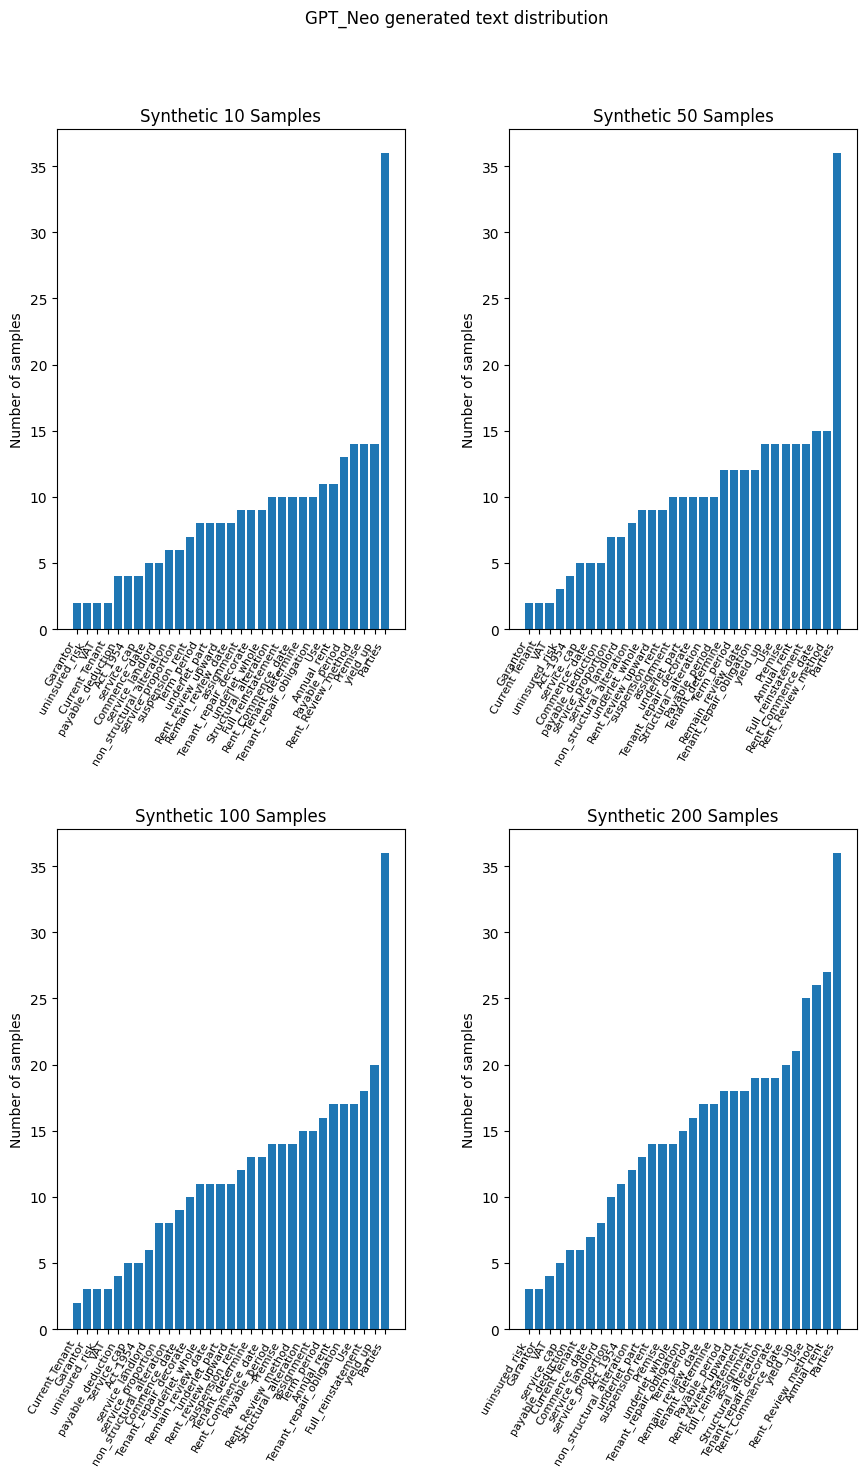

In [ ]:
# Visualise frequency of labelling
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2,figsize=(10,15))
figure.tight_layout(pad=5.0,h_pad=5.0)
# plot NEO-graphs
neo_10 = pd_neo_10['labels'].value_counts(ascending=True).sort_values()
neo_50 = pd_neo_50['labels'].value_counts(ascending=True).sort_values()
neo_100 = pd_neo_100['labels'].value_counts(ascending=True).sort_values()
neo_200 = pd_neo_200['labels'].value_counts(ascending=True).sort_values()
axis[0, 0].bar(return_to_label(list(neo_10.index)),list(neo_10.values))
axis[0, 1].bar(return_to_label(list(neo_50.index)),list(neo_50.values))
axis[1, 0].bar(return_to_label(list(neo_100.index)),list(neo_100.values))
axis[1, 1].bar(return_to_label(list(neo_200.index)),list(neo_200.values))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
figure.suptitle('GPT_Neo generated text distribution')
plt.draw()
# Define titles
axis[0,0].set_title('Synthetic 10 Samples')
axis[0,1].set_title('Synthetic 50 Samples')
axis[1,0].set_title('Synthetic 100 Samples')
axis[1,1].set_title('Synthetic 200 Samples')
# Define y_label
axis[0,0].set_ylabel('Number of samples')
axis[0,1].set_ylabel('Number of samples')
axis[1,0].set_ylabel('Number of samples')
axis[1,1].set_ylabel('Number of samples')
# Format xtick
axis[0, 0].set_xticklabels(axis[0,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
axis[0, 1].set_xticklabels(axis[0,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)
axis[1, 0].set_xticklabels(axis[1,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
axis[1, 1].set_xticklabels(axis[1,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)

# Save figure
plt.savefig('GPT_Neo_plot.png', dpi=300, bbox_inches='tight')

<ipython-input-16-a93f4e7a6acb>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0, 0].set_xticklabels(axis[0,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
<ipython-input-16-a93f4e7a6acb>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0, 1].set_xticklabels(axis[0,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)
<ipython-input-16-a93f4e7a6acb>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1, 0].set_xticklabels(axis[1,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
<ipython-input-16-a93f4e7a6acb>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1, 1].set_xticklabels(axis[1,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)


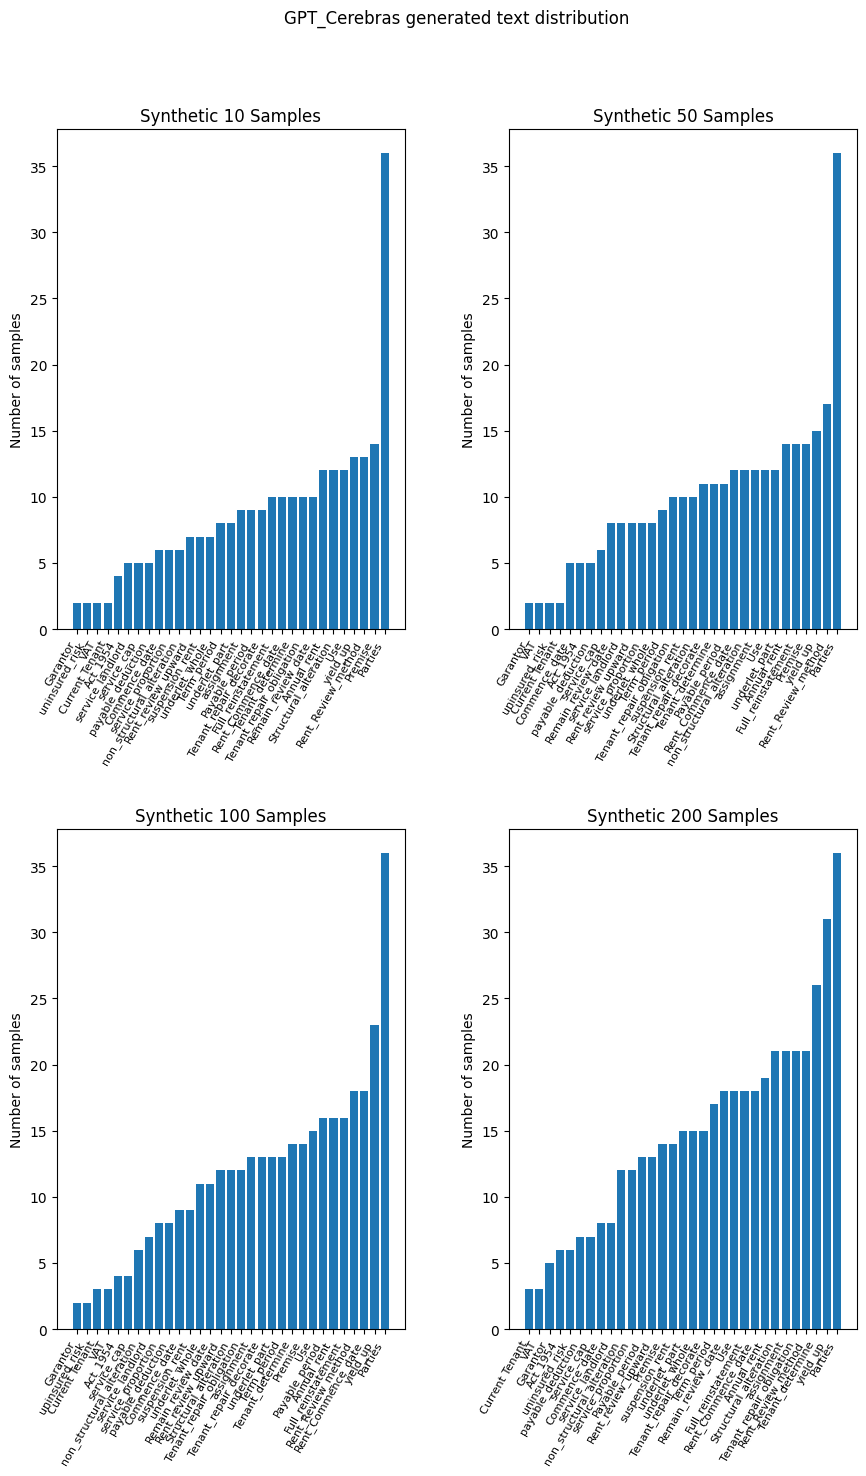

In [ ]:
# Cerebras
# Visualise frequency of labelling
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2,figsize=(10,15))
figure.tight_layout(pad=5.0,h_pad=5.0)
# plot NEO-graphs
cb_10 = pd_cb_10['labels'].value_counts(ascending=True).sort_values()
cb_50 = pd_cb_50['labels'].value_counts(ascending=True).sort_values()
cb_100 = pd_cb_100['labels'].value_counts(ascending=True).sort_values()
cb_200 = pd_cb_200['labels'].value_counts(ascending=True).sort_values()
axis[0, 0].bar(return_to_label(list(cb_10.index)),list(cb_10.values))
axis[0, 1].bar(return_to_label(list(cb_50.index)),list(cb_50.values))
axis[1, 0].bar(return_to_label(list(cb_100.index)),list(cb_100.values))
axis[1, 1].bar(return_to_label(list(cb_200.index)),list(cb_200.values))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
figure.suptitle('GPT_Cerebras generated text distribution')
plt.draw()
# Define titles
axis[0,0].set_title('Synthetic 10 Samples')
axis[0,1].set_title('Synthetic 50 Samples')
axis[1,0].set_title('Synthetic 100 Samples')
axis[1,1].set_title('Synthetic 200 Samples')
# Define y_label
axis[0,0].set_ylabel('Number of samples')
axis[0,1].set_ylabel('Number of samples')
axis[1,0].set_ylabel('Number of samples')
axis[1,1].set_ylabel('Number of samples')
# Format xtick
axis[0, 0].set_xticklabels(axis[0,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
axis[0, 1].set_xticklabels(axis[0,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)
axis[1, 0].set_xticklabels(axis[1,0].get_xticklabels(), rotation=60, ha='right',fontsize=8)
axis[1, 1].set_xticklabels(axis[1,1].get_xticklabels(), rotation=60, ha='right',fontsize=8)

# Save figure
plt.savefig('GPT_Cerebras_plot.png', dpi=300, bbox_inches='tight')

In [ ]:
# merge into one dataset
ds_gptneo = {'10': neo_ds_10, '50': neo_ds_50 , '100': neo_ds_100, '200': neo_ds_200}
ds_cerebras = {'10': cerebras_ds_10,'50': cerebras_ds_50, '100': cerebras_ds_100, '200': cerebras_ds_200}
ds_snorkel = {'100': snorkel_ds_200, '200': snorkel_ds_300, '300': snorkel_ds_400}

In [ ]:
# change abnormal encoding type (only execute this block if error related to encoding occurs)
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Load Model and functions

In [ ]:
# Let's evaluate the improvement in model performance after data augementation
#Model
model_bert_100 = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                                    num_labels=len(label),id2label=id_to_label,
                                                                    label2id = label_to_id)
tokenizer_bert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set meta-parameter
max_size = 216+200 # size of the largest augmented dataset
batch_size=16
steps = 5*int(max_size/batch_size) # 5 epochs in the large dataset
performance= [] # list of dicts to store both metrics and logs for all the experiment runs
prompt_list = ['10','50','100','200']

Reference:
Antoniadis (2022)

In [ ]:
# Precision accuracy
import evaluate
f1_metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

class LogAccumulatorCallback(TrainerCallback):
    def __init__(self):
        self.acc_logs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero and ('loss' in logs or 'eval_loss' in logs):
            self.acc_logs.append(logs.copy())

def train_and_evaluate(train_ds, test_ds, output_dir):
    def tokenize(dataset):
        return tokenizer_bert(dataset['text'], truncation=True)

    train_ds = train_ds.map(tokenize, batched=True)
    test_ds = test_ds.map(tokenize, batched=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer_bert) # Dynamic padding

    model = model_bert_100
    logger = LogAccumulatorCallback()
    training_args = TrainingArguments(
        output_dir = output_dir,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        weight_decay=0.01,
        learning_rate=1e-4,
        num_train_epochs=6,
        load_best_model_at_end=True,
        logging_steps=20,
        report_to='none'
    )

    trainer = Trainer(
        model=model, args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=data_collator,
        tokenizer=tokenizer_bert,
        compute_metrics=compute_metrics,
        callbacks=[neptune_callback]
    )

    trainer.train()
    model.save_pretrained(output_dir)
    metrics = trainer.evaluate()
    return metrics

## Model Comparison

### Model baseline

In [ ]:
# Instantiate run
run_baseline = neptune.init_run(
    custom_run_id="baseline",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZmViNmNiNy1hYmFiLTRhOWYtYjA3NC02NDRhYjJmZjUxODcifQ==",
    project='dducl/Dissertation-GPT'
)
neptune_callback = NeptuneCallback(
    run=run_baseline
)

In [ ]:
baseline=[]
metrics = train_and_evaluate(train_ds, test_ds,'baseline')
baseline.append({
    "id": "baseline",
    "metrics": metrics
})

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.890855,0.213600
2,3.176000,2.339100,0.422196
3,2.404400,1.939862,0.586400
4,1.752500,1.676134,0.610774
5,1.329200,1.518040,0.621465
6,1.068300,1.460408,0.646970


### GPT-Neo

In [ ]:
# train our model on the augmented datasets of GPT-Neo
for i in range(0,len(prompt_list)):
  augmented_gptneo_ds = concatenate_datasets([train_ds, ds_gptneo[prompt_list[i]]])
  metrics = train_and_evaluate(augmented_gptneo_ds, test_ds, "augmented_gptneo_"+ prompt_list[i])

  performance.append({
    "id": "augmented_gptneo_ds",
    "metrics": metrics
    })
  i+=1

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,1.118245,0.687879
2,0.958000,0.892809,0.759776
3,0.553100,0.754934,0.803355
4,0.285100,0.680133,0.808405
5,0.189400,0.713210,0.794084
6,0.128400,0.678451,0.804798


Map:   0%|          | 0/311 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.248100,0.685182,0.787121
2,0.125700,0.609160,0.849747
3,0.053400,0.660916,0.850902
4,0.026000,0.619692,0.834091
5,0.020000,0.633874,0.807792
6,0.015500,0.630903,0.822944


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.109800,0.576528,0.864971
2,0.047900,0.644453,0.848629
3,0.024200,0.607724,0.864971
4,0.008400,0.606588,0.863781
5,0.006600,0.612126,0.863781
6,0.005200,0.612620,0.863781


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.228500,0.922603,0.789971
2,0.120100,0.657120,0.851263
3,0.012000,1.062807,0.748773
4,0.032700,0.909907,0.796104
5,0.019900,0.873338,0.790043
6,0.005400,0.860856,0.790043


### GPT-Cerebras

In [ ]:
for i in range(0,len(prompt_list)):
  augmented_cerebras_ds = concatenate_datasets([train_ds, ds_cerebras[prompt_list[i]]])
  metrics = train_and_evaluate(augmented_cerebras_ds, test_ds, "augmented_cerebras_"+ prompt_list[i])

  performance.append({
    "id": "augmented_cerebras_" + prompt_list[i],
    "metrics": metrics,
    })
  i+=1

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.678215,0.804185
2,0.063300,0.596327,0.829798
3,0.013600,0.566129,0.874315
4,0.002800,0.587048,0.874315
5,0.001700,0.589545,0.874315
6,0.001600,0.589379,0.874315


Map:   0%|          | 0/311 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.336200,0.732269,0.834812
2,0.117400,0.869508,0.835678
3,0.074600,0.904376,0.828788
4,0.039700,0.911210,0.791306
5,0.020900,0.911219,0.789141
6,0.016100,0.928368,0.789141


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.397200,0.948710,0.796861
2,0.183200,0.799788,0.844661
3,0.095400,0.726884,0.866234
4,0.015700,0.715392,0.879942
5,0.016600,0.720452,0.868254
6,0.009500,0.711370,0.882395


Map:   0%|          | 0/461 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.579000,0.938894,0.814033
2,0.468500,1.021888,0.811688
3,0.141900,0.830581,0.843759
4,0.156400,0.875133,0.843326
5,0.035500,0.886044,0.843759
6,0.053200,0.891386,0.843759


# Visualisation

In [ ]:
# Convert list dictionary to pandas dataframe
df = pd.DataFrame(performance)
gptneo_names = ['augmented_gptneo_ds10','augmented_gptneo_ds50', 'augmented_gptneo_ds100', 'augmented_gptneo_ds200']
gpt_cerebras_names = ['augmented_cerebras_10','augmented_cerebras_50', 'augmented_cerebras_100', 'augmented_cerebras_200']

In [ ]:
# Extract f1_score and evaluation score from values in the metrics column
f1_score = []
eval_loss = []
for i in range(len(df)):
  f1 = df['metrics'][i]['eval_f1']
  loss = df['metrics'][i]['eval_loss']
  f1_score.append(f1)
  eval_loss.append(loss)
  i+=1
# Add new columns to dataframe, remove 'metrics column
df['f1_score'] = f1_score
df['Eval_loss'] = eval_loss
df.drop(['metrics'],axis=1,inplace=True)

In [ ]:
df.head()

,id,f1_score,Eval_loss
0,augmented_gptneo_ds,0.804798,0.678451
1,augmented_gptneo_ds,0.849747,0.609160
2,augmented_gptneo_ds,0.864971,0.576528
3,augmented_gptneo_ds,0.851263,0.657120
4,augmented_cerebras_10,0.874315,0.566129


In [ ]:
# Split pandas dataframe
df_neo = df.iloc[:4,:]
df_cerebras = df.iloc[4:,:]

# Add a reference to number of samples generated to the dataframe
df_neo['extra_sample'] = prompt_list
df_cerebras['extra_sample'] =prompt_list

# Plot on the same graph to compare f1 score and loss
from matplotlib import pyplot as plt
neo_x = df_neo['extra_sample']
neo_y_f1 = df_neo['f1_score']
neo_y_loss=df_neo['Eval_loss']
cerebras_y_f1 = df_cerebras['f1_score']
cerebras_y_loss = df_cerebras['Eval_loss']

In [ ]:
# Baseline
baseline_f1 = baseline[0]['metrics']['eval_f1']
baseline_loss = baseline[0]['metrics']['eval_loss']

In [ ]:
# Plot on the same graph to compare f1 score and loss
from matplotlib import pyplot as plt
neo_x = df_neo['extra_sample']
neo_y_f1 = df_neo['f1_score']
neo_y_loss=df_neo['Eval_loss']
cerebras_y_f1 = df_cerebras['f1_score']
cerebras_y_loss = df_cerebras['Eval_loss']

# Baselline as references

# Plot
fig, axs = plt.subplots()
# f1 graphs
f1_neo = axs.plot(neo_x,neo_y_f1,'red',label='GPT_Neo_f1')
f1_cerebras = axs.plot(neo_x,cerebras_y_f1,'lightsalmon',label='GPT_cerebras_f1')
baseline_f1_s = plt.axhline(y = baseline_f1, color = 'darkgrey', linestyle = '-',label='Baseline_f1')
axs.set_xlabel('Extra Sample size')
axs.set_ylabel('f1_score',color='r')
# Loss graphs
axs2=axs.twinx()
loss_neo = axs2.plot(neo_x,neo_y_loss,'limegreen',label='GPT_Neo_loss')
loss_cerebras = axs2.plot(neo_x,cerebras_y_loss,'darkgreen',label='GPT_cerebras_loss')
axs2.set_ylabel('Eval_loss',color='g')
graph = f1_neo +f1_cerebras + loss_cerebras + loss_neo
labs = [l.get_label() for l in graph]
axs.legend(graph, labs, bbox_to_anchor=(1.1, 1.0), loc='upper left')
plt.title('Data Augementation performance')
baseline_loss_s = plt.axhline(y = baseline_loss, color = 'lightgrey', linestyle = '-',label='Baseline_loss')
plt.legend(handles=[baseline_f1_s,baseline_loss_s],bbox_to_anchor=(1.15, 0.6), loc='upper left')
plt.show()